In [15]:
%matplotlib inline

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import sys, os
import csv
import datetime
import numpy as np
import netCDF4
import ast
#import scipy.stats
#import json

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

from scipy import stats

import selection_criteria as s_c

In [18]:
def ts_to_dt(ts):
    return datetime.datetime.utcfromtimestamp(ts)
def dt_to_ts(dt):
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()
def lin2z(array):
    """linear values to dB (for np.array or single number)"""
    return 10 * np.log10(array)

def z2lin(array):
    """dB to linear values (for np.array or single number)"""
    return 10 ** (array / 10.)

In [19]:
filename = {
    "Pun_larda3": '../cloud_collections/cloud_collection_lacros_dacapo_all.csv',
    "Lim_larda3": '../cloud_collections/cloud_collection_lacros_cycare_all.csv',
    "Lei_larda3": '../cloud_collections/cloud_collection_lacros_leipzig_all.csv',
}

larda_names = {
    "Pun_larda3": "lacros_dacapo",
    "Lim_larda3": "lacros_cycare",
    "Lei_larda3": "lacros_cycare",
}

camp = "Pun_larda3"
# camp = "Lim_larda3"
camp = "Lei_larda3"
#camp = "Davos_larda3"

larda_name = larda_names[camp]
withCTH = True
withCTH = False

162 
0 A_Unique_Identifier
1 Begin_Date
2 Begin_Date_Unix
3 CBH
4 CBP
5 CBT
6 CTH
7 CTH_AVG
8 CTH_DIFFSUM
9 CTH_STD
10 CTH_autocorr_08_time
11 CTP
12 CTT
13 CTT_MED
14 Cloud_Run
15 Cloud_Thickness_AVG
16 Cloud_Thickness_MED
17 Cloud_Thickness_STD
18 Cloud_Type
19 DIR
20 Date_Day
21 Date_Hour
22 Date_Month
23 Date_Year
24 End_Date
25 End_Date_Unix
26 ILCR_AVG
27 ILCR_MED
28 ILCR_N
29 ILCR_values
30 IWC_AVG
31 IWC_MED
32 IWC_N
33 IWC_STD
34 IWC_TOP_AVG
35 IWC_TOP_MED
36 IWC_TOP_N
37 IWC_TOP_STD
38 LDR_AVG
39 LDR_MED
40 LDR_N
41 LDR_STD
42 LDR_TOP_AVG
43 LDR_TOP_MED
44 LDR_TOP_N
45 LDR_TOP_STD
46 LDR_values
47 LDRcorr_AVG
48 LDRcorr_MED
49 LDRcorr_N
50 LDRcorr_STD
51 LDRcorr_TOP_AVG
52 LDRcorr_TOP_MED
53 LDRcorr_TOP_N
54 LDRcorr_TOP_STD
55 LLH_STD
56 LWC_AVG
57 LWC_MED
58 LWC_N
59 LWC_STD
60 N_Drizzle
61 N_Liquid
62 N_Melting
63 N_MixedPhase
64 N_Profiles
65 PATH_IWP_AVG
66 PATH_IWP_STD
67 PATH_LWP_AVG
68 PATH_LWP_S_AVG
69 SNR_TOP_AVG
70 SNR_TOP_MED
71 SNR_TOP_N
72 SNR_TOP_STD
73 VEL
74 Z

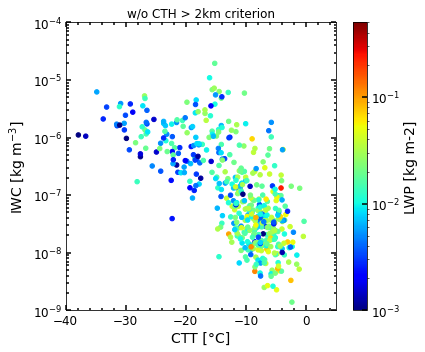

In [20]:
data = []
with open(filename[camp], 'r') as f:
#with open('cloud_collection_LEIPZIG_all.csv', 'r') as f:
    reader = csv.reader(f, delimiter=';')
    header = next(reader)
    print("\n".join(["{} {}".format(*e) for e in sorted(list(zip(range(len(header)),header)), key=lambda e: e[1])]))
    for row in reader:
        #data.append(row)
        comp = row[1].replace('_', '')
        if row[0][:14] == comp:
            data.append({k:v for k, v in zip(header, row)})
        else:
            print('corrupted row ', row)
            break
            

#[print(cloud['CBH']) for cloud in data]
data_filtered = []
for i, cloud in enumerate(data[:]):
    ffcloud = lambda s: float(cloud[s])
    
    dt_begin = ts_to_dt(ffcloud('Begin_Date_Unix'))
    dt_end = ts_to_dt(ffcloud('End_Date_Unix'))
    duration = dt_end-dt_begin

    if withCTH:
        conds = s_c.conditions_ice_w_CTH(cloud)
    else:
        conds = s_c.conditions_ice_wo_CTH(cloud)
    
    if all(conds[::2]):
        #print('cloud keys', cloud.keys())

        data_filtered.append(cloud)

    
print('len raw data ', len(data))
only_dates = sorted([d["Begin_Date"] for d in data])
print(only_dates[0], only_dates[-1])
print('len filtered ', len(data_filtered))


print(data_filtered[0].keys())

ilcr = np.array([float(d['ILCR_MED']) for d in data_filtered])
ilcr[ilcr == 0.0] = np.nan
iwc = np.array([float(d['IWC_TOP_MED']) for d in data_filtered])
iwc[iwc == 0.0] = np.nan
ctt = np.array([float(d['CTT']) for d in data_filtered])
ctt[ctt == 0.0] = np.nan
path_lwp_avg = np.array([float(d['PATH_LWP_S_AVG']) for d in data_filtered])
path_lwp_avg[path_lwp_avg == 0.0] = np.nan

cloud_thickness_med = np.array([float(d['Cloud_Thickness_MED']) for d in data_filtered])
cloud_thickness_med[cloud_thickness_med == 0.0] = np.nan

z_top_med = np.array([float(d['Z_TOP_MED']) for d in data_filtered])
z_top_med = 10*np.log10(z_top_med)

v_top_med = np.array([float(d['v_TOP_MED']) for d in data_filtered])

snr_top_med = np.array([float(d['SNR_TOP_MED']) for d in data_filtered])
#z_top_med[z_top_med == 0.0] = np.nan

v_dl_std = np.array([float(d['v_dl_std']) for d in data_filtered])

cbh = np.array([float(d['CBH']) for d in data_filtered])

def convert_to_float(e):
    if e[0] == '[':
        return float(e[1:-1])
    else:
        return float(e)


# CTT - IWC colored by LWP
#
fig, ax = plt.subplots(figsize=(6, 5))

sc = ax.scatter(ctt-273.15, iwc,
                #label=trace_geo_names[int(elem)],
                norm=matplotlib.colors.LogNorm(vmin=1e-3,vmax=5e-1),
                c=path_lwp_avg, cmap='jet', s=20)
cbar = fig.colorbar(sc)
cbar.ax.set_ylabel('LWP [kg m-2]', fontsize=14)
cbar.ax.tick_params(axis='y', which='major', direction='in',
                     right=True,
                     width=1.5, length=5, labelsize=12)

ax.set_xlabel('CTT [°C]', fontsize=14)
ax.set_ylabel('IWC [kg m$\mathrm{^{-3}}$]', fontsize=14)
ax.set_yscale('log')
ax.set_ylim([1e-9, 1e-4])
ax.set_xlim([-40, 5])

title = 'w/ CTH > 2km criterion' if withCTH else 'w/o CTH > 2km criterion'
ax.set_title(title)

ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.tick_params(axis='both', which='major', direction='in',
               top=True, right=True,
               width=1.5, length=5, labelsize=12)
ax.tick_params(axis='both', which='minor', direction='in', 
               top=True, right=True,
               width=1.5, length=2.5)
#ax.legend(fontsize=11)
plt.tight_layout()
fname_cth = 'wCTH' if withCTH else 'woCTH'
fname = '../plots/collector_alone/{}_iwc_colored_LWP_{}.png'.format(camp, fname_cth)
plt.savefig(fname, dpi=250)



In [21]:
def print_cloud_props(cloud):
    ffcloud = lambda s: float(cloud[s])
    
    dt_begin = ts_to_dt(ffcloud('Begin_Date_Unix'))
    dt_end = ts_to_dt(ffcloud('End_Date_Unix'))

    iwc_n = ffcloud('IWC_TOP_N')
    n_prof = ffcloud('N_Profiles')
    print(cloud['A_Unique_Identifier'])
    print(dt_begin.strftime("%Y%m%d-%H%M"), '-', dt_end.strftime("%Y%m%d-%H%M"), ':', 
              "{:>7.1f}".format(ffcloud('CBH')), "{:>7.1f}".format(ffcloud('CTH')), 
              "{:>7.2f}".format(ffcloud('CTT')-273.15),
              "{:>7.2f}".format(ffcloud('CTH_STD')),
              "{:>7.2f}".format(ffcloud('Cloud_Thickness_MED')),
              "  {:.2e}".format(ffcloud('IWC_TOP_MED')), 
              "  {:.2e}".format(float(ffcloud('PATH_LWP_S_AVG'))), 
              "  {:.2f}".format(iwc_n/n_prof),
              "  {:.2f}".format(ffcloud('N_Profiles')/(duration.seconds/30.)),
              cloud['Cloud_Run'], cloud['Cloud_Type'])

    print(cloud['v_dl_autocor_coeff'][:5])
    cbh = max(ffcloud('CBH') - 700, 0)
    cth = ffcloud('CTH') + 700
    link = get_explorer_link('lacros_leipzig', [dt_begin, dt_end], [cbh, cth], 
                             ["CLOUDNET|CLASS", "CLOUDNET|Z", "POLLYNET|attbsc1064", "POLLYNET|voldepol532", "MIRA|VELg"])
    print(link)
    
    
    
def get_explorer_link(campaign, time_interval, range_interval, params):

    s = "http://larda3.tropos.de/explorer/{}?interval={}-{}%2C{}-{}&params={}".format(
        campaign, dt_to_ts(time_interval[0]), dt_to_ts(time_interval[1]),
        *range_interval, ",".join(params))
    return s

In [22]:
clouds_standard = {
    'layered_all': [],
    'liquid_only': [],
    'ice_producing': []
}

for i, cloud in enumerate(data[:]):
    ffcloud = lambda s: float(cloud[s])

    dt_begin = ts_to_dt(ffcloud('Begin_Date_Unix'))
    dt_end = ts_to_dt(ffcloud('End_Date_Unix'))
    duration = dt_end-dt_begin

    conds = s_c.standard(cloud)

    if all(conds[::2]):
        clouds_standard['layered_all'].append(cloud)
        if ffcloud('IWC_TOP_N')/ffcloud('N_Profiles') < 0.05:
            clouds_standard['liquid_only'].append(cloud)
        else:
            clouds_standard['ice_producing'].append(cloud)


clouds_above_2km = {
    'layered_all': [],
    'liquid_only': [],
    'ice_producing': []
}

for i, cloud in enumerate(data[:]):
    ffcloud = lambda s: float(cloud[s])

    dt_begin = ts_to_dt(ffcloud('Begin_Date_Unix'))
    dt_end = ts_to_dt(ffcloud('End_Date_Unix'))
    duration = dt_end-dt_begin

    conds = s_c.with_gt_cbh(cloud, 2000)

    if all(conds[::2]):
        clouds_above_2km['layered_all'].append(cloud)
        if ffcloud('IWC_TOP_N')/ffcloud('N_Profiles') < 0.05:
            clouds_above_2km['liquid_only'].append(cloud)
            if float(cloud['CTT'])-273.15 < -25:
                print_cloud_props(cloud)
        else:
            clouds_above_2km['ice_producing'].append(cloud)
            
clouds_below_2km = {
    'layered_all': [],
    'liquid_only': [],
    'ice_producing': []
}

for i, cloud in enumerate(data[:]):
    ffcloud = lambda s: float(cloud[s])

    dt_begin = ts_to_dt(ffcloud('Begin_Date_Unix'))
    dt_end = ts_to_dt(ffcloud('End_Date_Unix'))
    duration = dt_end-dt_begin

    conds = s_c.with_lt_cbh(cloud, 2000)

    if all(conds[::2]):
        clouds_below_2km['layered_all'].append(cloud)
        if ffcloud('IWC_TOP_N')/ffcloud('N_Profiles') < 0.05:
            clouds_below_2km['liquid_only'].append(cloud)
        else:
            clouds_below_2km['ice_producing'].append(cloud)
          


/home/martin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("plasma_r"))


no cases  1063 1063
573


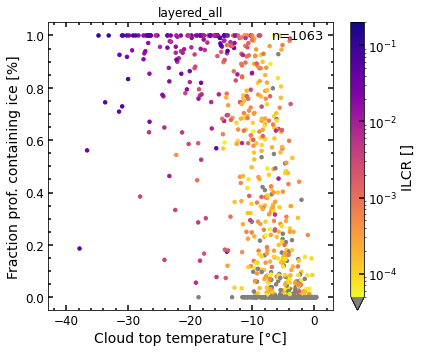

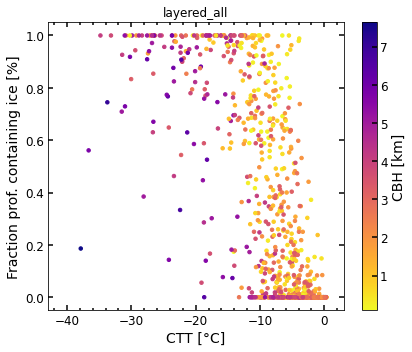

In [23]:
assert len([float(d['CTT']) for d in clouds_standard['layered_all']]) == \
          len([float(d['IWC_TOP_N'])/float(d['N_Profiles']) for d in clouds_standard['layered_all']]) == \
          len([float(d['ILCR_MED']) for d in clouds_standard['layered_all']])


ctt = np.array([float(d['CTT']) for d in clouds_standard['layered_all']])
ctt[ctt == 0.0] = np.nan
frac_prof_ice = np.array([float(d['IWC_TOP_N'])/float(d['N_Profiles']) for d in clouds_standard['layered_all']])
ilcr = np.array([float(d['ILCR_MED']) for d in clouds_standard['layered_all']])
ilcr[ilcr == 0.0] = 1e-50


fig, ax = plt.subplots(figsize=(6, 5))
# ax.set_facecolor('lightgrey')
sc = ax.scatter(ctt-273.15, frac_prof_ice, s=12,
                #label=trace_geo_names[int(elem)],
                norm=matplotlib.colors.LogNorm(vmin=5e-5,vmax=2e-1),
                #vmin=-0.5, vmax=0.5,
                c=ilcr, cmap='plasma_r')
sc.cmap.set_under('grey')
cbar = fig.colorbar(sc, extend='min')
cbar.ax.set_ylabel('ILCR []', fontsize=14)
cbar.ax.tick_params(axis='y', which='major', direction='in',
                     right=True,
                     width=1.5, length=5, labelsize=12)
ax.set_xlabel('Cloud top temperature [°C]', fontsize=14)
ax.set_ylabel('Fraction prof. containing ice [%]', fontsize=14)
ax.set_ylim([-0.05, 1.05])
ax.set_xlim([-43, 3])

print('no cases ', len(clouds_standard['layered_all']), ctt[~np.isnan(ctt)].shape[0])

print(np.sum(frac_prof_ice > 1e-50))

ax.set_title('layered_all')
ax.text(0.97, 0.94, 'n={}'.format(ctt[~np.isnan(ctt)].shape[0]), horizontalalignment='right',
        #verticalalignment='bottom', 
        transform=ax.transAxes, color='k', fontsize=13)


ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.tick_params(axis='both', which='major', direction='in',
               top=True, right=True,
               width=1.5, length=5, labelsize=12)
ax.tick_params(axis='both', which='minor', direction='in', 
               top=True, right=True,
               width=1.5, length=2.5)
#ax.legend(fontsize=11)
plt.tight_layout()
fname = '../plots/collector_alone/{}_frac_profiles_ilcr_{}.png'.format(camp, 'layered_all')
plt.savefig(fname, dpi=250)




ctt = np.array([float(d['CTT']) for d in clouds_standard['layered_all']])
ctt[ctt == 0.0] = np.nan
frac_prof_ice = np.array([float(d['IWC_TOP_N'])/float(d['N_Profiles']) for d in clouds_standard['layered_all']])
cbh = np.array([float(d['CBH']) for d in clouds_standard['layered_all']])

fig, ax = plt.subplots(figsize=(6, 5))
# ax.set_facecolor('lightgrey')
sc = ax.scatter(ctt-273.15, frac_prof_ice, s=12,
                #label=trace_geo_names[int(elem)],
                #norm=matplotlib.colors.LogNorm(vmin=5e-5,vmax=2e-1),
                #vmin=-0.5, vmax=0.5,
                c=cbh/1000., cmap='plasma_r')
#sc.cmap.set_under('grey')
cbar = fig.colorbar(sc)
cbar.ax.set_ylabel('CBH [km]', fontsize=14)
cbar.ax.tick_params(axis='y', which='major', direction='in',
                     right=True,
                     width=1.5, length=5, labelsize=12)
ax.set_xlabel('CTT [°C]', fontsize=14)
ax.set_ylabel('Fraction prof. containing ice [%]', fontsize=14)
ax.set_ylim([-0.05, 1.05])
ax.set_xlim([-43, 3])

ax.set_title('layered_all')

ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.tick_params(axis='both', which='major', direction='in',
               top=True, right=True,
               width=1.5, length=5, labelsize=12)
ax.tick_params(axis='both', which='minor', direction='in', 
               top=True, right=True,
               width=1.5, length=2.5)
#ax.legend(fontsize=11)
plt.tight_layout()
fname = '../plots/collector_alone/{}_frac_profiles_cbh_{}.png'.format(camp, 'layered_all')
plt.savefig(fname, dpi=250)


In [24]:
print(clouds_standard.keys())

selected_cloud_type = 'layered_all'
#selected_cloud_type = 'ice_producing'
#selected_cloud_type = 'liquid_only'

clouds_for_plots = clouds_standard[selected_cloud_type]

dict_keys(['layered_all', 'liquid_only', 'ice_producing'])


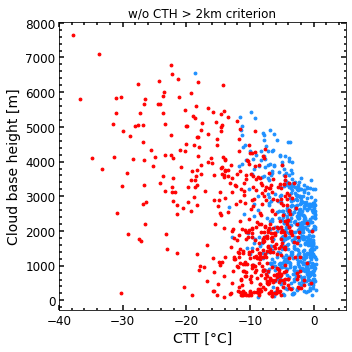

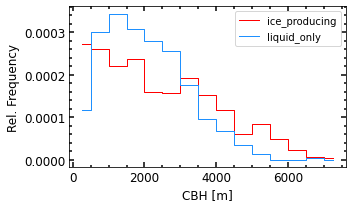

In [25]:
ctt_liq = np.array([float(d['CTT']) for d in clouds_standard['liquid_only']])
ctt_liq[ctt_liq == 0.0] = np.nan
cbh_liq = np.array([float(d['CBH']) for d in clouds_standard['liquid_only']])
cbh_liq[cbh_liq == 0.0] = np.nan

ctt_ice = np.array([float(d['CTT']) for d in clouds_standard['ice_producing']])
ctt_ice[ctt_ice == 0.0] = np.nan
cbh_ice = np.array([float(d['CBH']) for d in clouds_standard['ice_producing']])
cbh_ice[cbh_ice == 0.0] = np.nan

fig, ax = plt.subplots(figsize=(5, 5))

sc = ax.scatter(ctt_liq-273.15, cbh_liq,
                c='dodgerblue',
                #norm=matplotlib.colors.LogNorm(vmin=1e-3,vmax=5e-1),
                #c=path_lwp_avg, cmap='jet', 
                s=8)
sc = ax.scatter(ctt_ice-273.15, cbh_ice,
                c='red',
                #norm=matplotlib.colors.LogNorm(vmin=1e-3,vmax=5e-1),
                #c=path_lwp_avg, cmap='jet', 
                s=8)

ax.set_xlabel('CTT [°C]', fontsize=14)
ax.set_ylabel('Cloud base height [m]', fontsize=14)
#ax.set_ylim([-50, 0])
ax.set_xlim([-40, 5])

title = 'w/ CTH > 2km criterion' if withCTH else 'w/o CTH > 2km criterion'
ax.set_title(title)

ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.tick_params(axis='both', which='major', direction='in',
               top=True, right=True,
               width=1.5, length=5, labelsize=12)
ax.tick_params(axis='both', which='minor', direction='in', 
               top=True, right=True,
               width=1.5, length=2.5)
#ax.legend(fontsize=11)
plt.tight_layout()
fname_cth = 'wCTH' if withCTH else 'woCTH'
# fname = '../plots/collector_alone/{}_z_top_med_colored_LWP_{}_{}.png'.format(camp, save, fname_cth)


hist_cbh_liq, bin_edges = np.histogram(cbh_liq, bins=np.arange(0, 8000, 500), density=True)
hist_cbh_ice, bin_edges = np.histogram(cbh_ice, bins=np.arange(0, 8000, 500), density=True)
width = np.diff(bin_edges)
center = (bin_edges[:-1] + bin_edges[1:]) / 2
fig, ax = plt.subplots(figsize=(5,3))

# ax.step(center, hist_v_DL_perc_all, where='mid', color='dimgrey', linewidth=1, label='layered_all')
ax.step(center, hist_cbh_ice, where='mid', color='red', linewidth=1, label='ice_producing')
ax.step(center, hist_cbh_liq, where='mid', color='dodgerblue', linewidth=1, label='liquid_only')
ax.set_xlabel('CBH [m]', fontsize=12)
ax.set_ylabel('Rel. Frequency', fontsize=12)

ax.legend()
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.tick_params(axis='both', which='both', right=True, top=True)

ax.tick_params(axis='both', which='major', direction='in',
               top=True, right=True,
               width=1.5, length=5, labelsize=12)
ax.tick_params(axis='both', which='minor', direction='in', 
               top=True, right=True,
               width=1.5, length=2.5)
plt.tight_layout()
fname = '../plots/collector_alone/{}_hist_cbh_ice_liq.png'.format(camp)
# plt.savefig(fname, dpi=250)

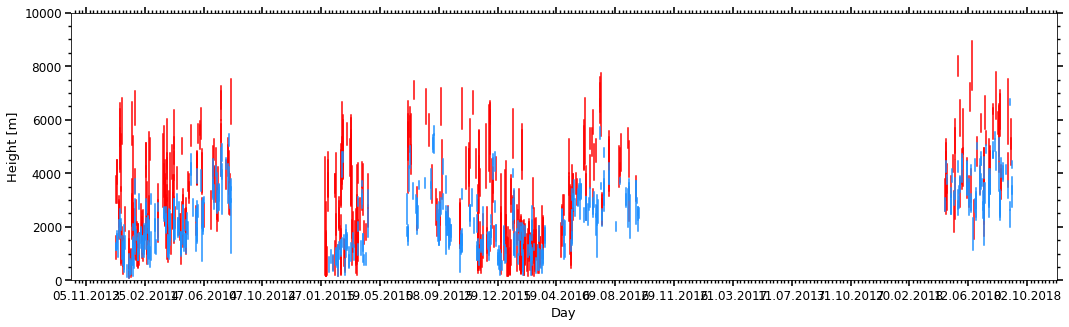

In [26]:
#day_ticker_interval = [21, 7]
#if camp == 'Lim_larda3':
#    day_ticker_interval = [49, 7]
day_ticker_interval = [112, 7]

fig, ax = plt.subplots(figsize=(15, 5))

#ax.bar(dt_list, no_profiles, width=0.6)

for cloud in clouds_standard['ice_producing']:
    ffcloud = lambda s: float(cloud[s])

    dt_begin = ts_to_dt(ffcloud('Begin_Date_Unix'))
    dt_end = ts_to_dt(ffcloud('End_Date_Unix'))
       
    ax.plot([dt_begin, dt_begin], [ffcloud('CBH'), ffcloud('CTH')], color='red')
    
for cloud in clouds_standard['liquid_only']:
    ffcloud = lambda s: float(cloud[s])

    dt_begin = ts_to_dt(ffcloud('Begin_Date_Unix'))
    dt_end = ts_to_dt(ffcloud('End_Date_Unix'))
    
    ax.plot([dt_begin, dt_begin], [ffcloud('CBH'), ffcloud('CTH')], color='dodgerblue')

ax.set_ylabel("Height [m]", fontsize=13)
ax.set_xlabel("Day", fontsize=13)

ax.set_ylim(0, 10000)

ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d.%m.%Y'))
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=day_ticker_interval[0]))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator(interval=day_ticker_interval[1]))
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.tick_params(axis='both', which='major', direction='out',
               top=True, right=True,
               width=1.6, length=6, labelsize=12)
ax.tick_params(axis='both', which='minor', direction='out', 
               top=True, right=True,
               width=1.4, length=3)
plt.tight_layout(rect=[0, 0.02, 1, 0.95])

fname = '../plots/collector_alone/{}_cloud_base_top_timeseries.png'.format(camp)
plt.savefig(fname, dpi=250)

/home/martin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/home/martin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


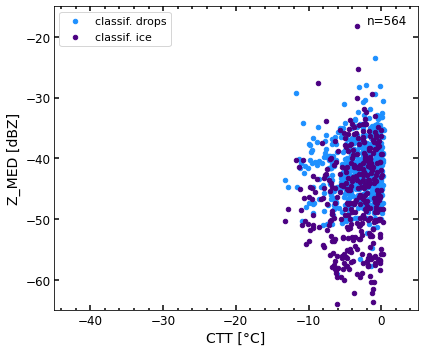

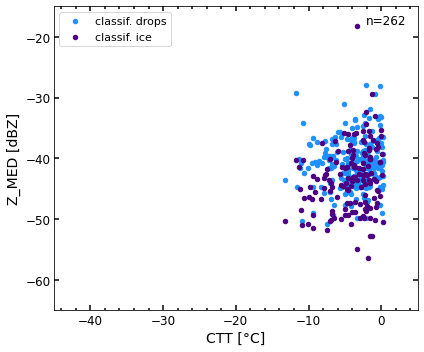

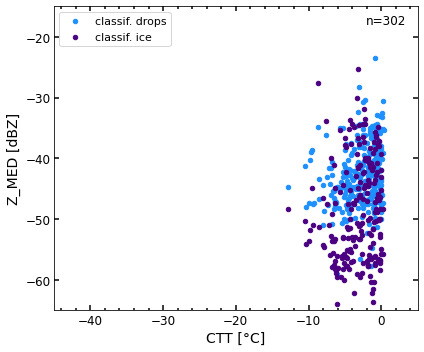

In [27]:

def liquid_z(clouds, which='liquid_only', save=False):
    ctt_liquid = np.array([float(d['CTT']) for d in clouds[which]])
    Z_MED_liquid = np.array([float(d['Z_MED_drop']) for d in clouds[which]])
    Z_MED = np.array([float(d['Z_MED']) for d in clouds[which]])

    fig, ax = plt.subplots(figsize=(6, 5))
    sc = ax.scatter(ctt_liquid-273.15, 10*np.log10(Z_MED_liquid),
                    marker='o', s=20, label='classif. drops', color='dodgerblue')
    sc = ax.scatter(ctt_liquid-273.15, 10*np.log10(Z_MED),
                    marker='o', s=20, label='classif. ice', color='indigo')

    # ax.step(bin_edges, np.append(bin_means, bin_means[-1]), color='k', 
    #         linewidth=1,
    #         where='post', label='median')

    cbar.ax.tick_params(axis='y', which='major', direction='in',
                         right=True,
                         width=1.5, length=5, labelsize=12)
    ax.set_xlabel('CTT [°C]', fontsize=14)
    ax.set_ylabel('Z_MED [dBZ]', fontsize=14)
    #ax.set_yscale('log')
    ax.set_ylim([-65, -15])
    ax.set_xlim([-45, 5])
    handles, labels = ax.get_legend_handles_labels()
    #ax.legend(handles[::-1], labels[::-1], loc='upper left', fontsize=12)
    ax.text(0.97, 0.94, 'n={}'.format(Z_MED_liquid.shape[0]), horizontalalignment='right',
            #verticalalignment='bottom', 
            transform=ax.transAxes, color='k', fontsize=12)

    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.tick_params(axis='both', which='major', direction='in',
                   top=True, right=True,
                   width=1.5, length=5, labelsize=12)
    ax.tick_params(axis='both', which='minor', direction='in', 
                   top=True, right=True,
                   width=1.5, length=2.5)
    ax.legend(fontsize=11, loc='upper left')
    plt.tight_layout()
    fname = '../plots/collector_alone/{}_liquid_layer_Z.png'.format(camp)
    if save:
        plt.savefig(fname, dpi=250)
        
liquid_z(clouds_standard, which='liquid_only', save=True)
liquid_z(clouds_above_2km, which='liquid_only', save=False)
liquid_z(clouds_below_2km, which='liquid_only', save=False)
